## 載入套件

In [1]:
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM


## 資料前處理

In [2]:
#讀取csv檔保留“text”,“stars” 兩個欄位
df = pd.read_csv('yelp.csv')
cols = ['text','stars']
df = df[cols]
df.head()
## 將stars欄位內 >= 4 轉成 1, 其餘轉成0
df['stars'] = [0 if star < 4 else 1 for star in df['stars']]
df

,text,stars
0,My wife took me here on my birthday for breakf...,1
1,I have no idea why some people give bad review...,1
2,love the gyro plate. Rice is so good and I als...,1
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1
4,General Manager Scott Petello is a good egg!!!...,1
...,...,...
9995,First visit...Had lunch here today - used my G...,0
9996,Should be called house of deliciousness!\n\nI ...,1
9997,I recently visited Olive and Ivy for business ...,1
9998,My nephew just moved to Scottsdale recently so...,0


In [3]:
## 將text欄位內的文字利用分割符號切割
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

for i, line in enumerate(df['text']):
    df['text'][i] = tokenize(line)
df['text'][0]

['My',
 'wife',
 'took',
 'me',
 'here',
 'on',
 'my',
 'birthday',
 'for',
 'breakfast',
 'and',
 'it',
 'was',
 'excellent',
 '.',
 'The',
 'weather',
 'was',
 'perfect',
 'which',
 'made',
 'sitting',
 'outside',
 'overlooking',
 'their',
 'grounds',
 'an',
 'absolute',
 'pleasure',
 '.',
 'Our',
 'waitress',
 'was',
 'excellent',
 'and',
 'our',
 'food',
 'arrived',
 'quickly',
 'on',
 'the',
 'semi-busy',
 'Saturday',
 'morning',
 '.',
 'It',
 'looked',
 'like',
 'the',
 'place',
 'fills',
 'up',
 'pretty',
 'quickly',
 'so',
 'the',
 'earlier',
 'you',
 'get',
 'here',
 'the',
 'better',
 '.',
 'Do',
 'yourself',
 'a',
 'favor',
 'and',
 'get',
 'their',
 'Bloody',
 'Mary',
 '.',
 'It',
 'was',
 'phenomenal',
 'and',
 'simply',
 'the',
 'best',
 'I',
 "'ve",
 'ever',
 'had',
 '.',
 'I',
 "'m",
 'pretty',
 'sure',
 'they',
 'only',
 'use',
 'ingredients',
 'from',
 'their',
 'garden',
 'and',
 'blend',
 'them',
 'fresh',
 'when',
 'you',
 'order',
 'it',
 '.',
 'It',
 'was',
 'ama

In [4]:
## 去除停頓詞和標點符號
def stopword(text):
    lower = [word.lower() for word in text]
    stopword = nltk.corpus.stopwords.words('english')
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    return no_alpha
for i, line in enumerate(df['text']):
    df['text'][i] = stopword(line)

In [5]:
## 去除詞幹
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
def clean_stem(text):
    lemma_sent = []
    wordnetLemmatizer = nltk.WordNetLemmatizer()
    tagged_sent = nltk.pos_tag(text)
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemma_sent.append(wordnetLemmatizer.lemmatize(tag[0], pos=wordnet_pos))
    return lemma_sent
for i, line in enumerate(df['text']):
    df['text'][i] = ' '.join(clean_stem(line))

In [6]:
X = df['text']
y = df['stars']

In [7]:
# 將yelp.csv的資料切成兩部分，80%為train，20%為test
Ｘ_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
# 使用Tokenizer模組建立token，建立一個3800字的字典
tokenizer = Tokenizer(num_words=3800)

# 讀取所有訓練集資料，依照每個英文字在訓練資料出現的次數進行排序(頻率)，
# #前3800名的英文單字會加進字典中
tokenizer.fit_on_texts(X_train)  

# 透過texts_to_sequences將訓練和測試集資料中的文字轉換為數字list
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

# 截長補短
# 長度小於380的，前面的數字補 0，長度大於380的，截去前面的數字 。
x_train = sequence.pad_sequences(X_train_sequence, maxlen=380)
x_test = sequence.pad_sequences(X_test_sequence, maxlen=380)

### 畫圖function

In [9]:
# 宣告 function plot出訓練過程中的Accuracy與Loss值變化
import matplotlib.pyplot as plt

def show_train_history(train, val,y_label,title):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## 建模

### CNN

In [10]:
# 建立模型
modelCNN = Sequential()

# 輸出的維度是32,希望將數字list轉為32維度的向量
# 輸入的維度是3800,也就是我們之前建立的字典3800字
# 數字list截長補短後都是380個數字
modelCNN.add(Embedding(output_dim=32, input_dim=3800, input_length=380))

# 隨機在神經網路中放棄20%的神經元，避免overfitting
modelCNN.add(Dropout(0.2))

# 建立卷積層1(Convolution1)
# 隨機產生32個filter weight
# 濾鏡大小3
modelCNN.add(Conv1D(filters=32,padding='same', activation='relu', kernel_size=3))
modelCNN .add(Dropout(0.2))

# 建立池化層1(Pooling1)
modelCNN.add(MaxPooling1D(pool_size=2))


# 建立卷積層2(Convolution2)
modelCNN.add(Conv1D(filters=64,padding='same', activation='relu', kernel_size=4))
modelCNN .add(Dropout(0.2))

# 建立池化層2(Pooling2)
modelCNN.add(MaxPooling1D(pool_size=3))


# 建立平坦層
modelCNN.add(Flatten())
modelCNN.add(Dropout(0.2))

# 建立隱藏層 (250個神經元)
modelCNN.add(Dense(250, activation='relu'))
modelCNN.add(Dropout(0.2))

# 建立輸出層 (1個神經元)
modelCNN.add(Dense(1, activation='sigmoid'))

# 查看模型摘要
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 380, 32)           121600    
_________________________________________________________________
dropout (Dropout)            (None, 380, 32)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 380, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 190, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 190, 64)           8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 190, 64)           0

Epoch 1/5
26/26 - 5s - loss: 0.6305 - accuracy: 0.6714 - precision: 0.6826 - val_loss: 0.6232 - val_accuracy: 0.6969 - val_precision: 0.6969
Epoch 2/5
26/26 - 4s - loss: 0.6194 - accuracy: 0.6811 - precision: 0.6811 - val_loss: 0.6182 - val_accuracy: 0.6969 - val_precision: 0.6969
Epoch 3/5
26/26 - 4s - loss: 0.5422 - accuracy: 0.7116 - precision: 0.7059 - val_loss: 0.4808 - val_accuracy: 0.8044 - val_precision: 0.8234
Epoch 4/5
26/26 - 5s - loss: 0.3851 - accuracy: 0.8380 - precision: 0.8641 - val_loss: 0.4310 - val_accuracy: 0.8150 - val_precision: 0.8247
Epoch 5/5
26/26 - 5s - loss: 0.2906 - accuracy: 0.8863 - precision: 0.9103 - val_loss: 0.4356 - val_accuracy: 0.8125 - val_precision: 0.8528


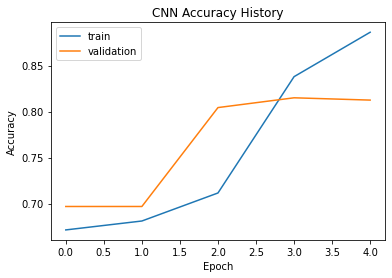

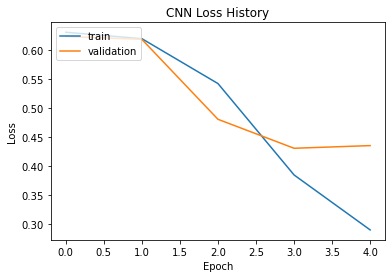

In [11]:
# 定義訓練模型
modelCNN.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy","Precision"])


# 模型訓練
train_history = modelCNN.fit(x_train,y_train,
         epochs=5, 
         batch_size=250,
         verbose=2,
         validation_split=0.2)
    
# 畫出accuracy圖
show_train_history('accuracy', 'val_accuracy', "Accuracy", "CNN Accuracy History")
show_train_history('loss', 'val_loss', "Loss", "CNN Loss History")


In [12]:
# 準確率
scores = modelCNN.evaluate(x_test, y_test,verbose=1)
print("CNN Accuracy：",scores) 

63/63 [==============================] - 0s 5ms/step - loss: 0.4342 - accuracy: 0.8140 - precision: 0.8514
CNN Accuracy： [0.43418076634407043, 0.8140000104904175, 0.8514167070388794]


In [13]:
import numpy as np
# pred = modelCNN.predict(x_test)
y_pred = (modelCNN.predict(x_test) > 0.5).astype("int32")
# print(y_pred)

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve,auc
# make prediction
# y_pred = modelCNN.predict_classes(x_test)
# pred = modelCNN.predict(x_test)
# y_pred = np.argmax(pred,axis=1)
# cm = confusion_matrix(y_test, y_pred)
# print('condusion matrix:\n',cm)
# sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

Area under test roc : 0.7675434410419016
Testing Accuracy : 0.814
Testing Precision : 0.8514167242570836
Testing Recall : 0.8869690424766019
Testing f1-score : 0.8688293370944994


### LSTM

In [15]:
# print(y_test)
print(y_pred)

[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [16]:
# 建立模型
modelLSTM = Sequential()

# 輸出的維度是32,希望將數字list轉為32維度的向量
# 輸入的維度是3800,也就是我們之前建立的字典3800字
# 數字list截長補短後都是380個數字
modelLSTM .add(Embedding(output_dim=32, input_dim=3800 ,input_length=380))

# 隨機在神經網路中放棄20%的神經元，避免overfitting
modelLSTM .add(Dropout(0.8))

# 建立LSTM層 (32個神經元)
modelLSTM .add(LSTM(32))

# 建立隱藏層 (256個神經元)
modelLSTM .add(Dense(units=256,activation='relu')) 

# 放棄20%的神經元，避免overfitting
modelLSTM .add(Dropout(0.8))

# 建立輸出層 (1個神經元)
modelLSTM .add(Dense(units=1,activation='sigmoid'))

# 查看模型摘要
modelLSTM .summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 138,625
Trainable params: 138,625
Non-trainable params: 0
________________________________________________

Epoch 1/7
26/26 - 13s - loss: 0.6602 - accuracy: 0.6755 - precision: 0.6817 - val_loss: 0.6092 - val_accuracy: 0.6969 - val_precision: 0.6969
Epoch 2/7
26/26 - 9s - loss: 0.6208 - accuracy: 0.6811 - precision: 0.6811 - val_loss: 0.5998 - val_accuracy: 0.6969 - val_precision: 0.6969
Epoch 3/7
26/26 - 8s - loss: 0.5755 - accuracy: 0.6825 - precision: 0.6821 - val_loss: 0.5034 - val_accuracy: 0.7050 - val_precision: 0.7028
Epoch 4/7
26/26 - 8s - loss: 0.4712 - accuracy: 0.7805 - precision: 0.7851 - val_loss: 0.4604 - val_accuracy: 0.7906 - val_precision: 0.8679
Epoch 5/7
26/26 - 8s - loss: 0.3998 - accuracy: 0.8227 - precision: 0.8611 - val_loss: 0.4133 - val_accuracy: 0.8194 - val_precision: 0.8714
Epoch 6/7
26/26 - 8s - loss: 0.3616 - accuracy: 0.8431 - precision: 0.8734 - val_loss: 0.4083 - val_accuracy: 0.8225 - val_precision: 0.8604
Epoch 7/7
26/26 - 8s - loss: 0.3360 - accuracy: 0.8561 - precision: 0.8798 - val_loss: 0.4024 - val_accuracy: 0.8269 - val_precision: 0.8631


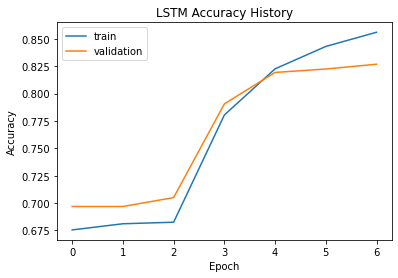

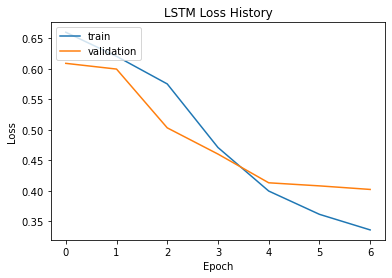

In [17]:
# 定義訓練模型
# loss function 使用cross entropy
# adam 最優化可以更快收斂
modelLSTM.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy","Precision"])

# 模型訓練
train_history = modelLSTM.fit(x_train,y_train,
         epochs=7, # 執行 7 次訓練週期
         batch_size=250, # 每一批次訓練500筆資料
         verbose=2, # verbose 顯示訓練過程
         validation_split=0.2)

# 畫出accuracy圖
show_train_history('accuracy', 'val_accuracy', "Accuracy", "LSTM Accuracy History")
show_train_history('loss', 'val_loss', "Loss", "LSTM Loss History")

In [18]:
scores = modelLSTM.evaluate(x_test,y_test,verbose=1)
print('LSTM accuracy:',scores[1])

63/63 [==============================] - 2s 30ms/step - loss: 0.3920 - accuracy: 0.8315 - precision: 0.8623
LSTM accuracy: 0.8314999938011169


In [19]:
import numpy as np
y_pred = (modelLSTM.predict(x_test) > 0.5).astype("int32")
# print(y_pred)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve,auc
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

Area under test roc : 0.7870178241714476
Testing Accuracy : 0.8315
Testing Precision : 0.8622589531680441
Testing Recall : 0.9013678905687545
Testing f1-score : 0.881379795846533
